In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound
from multiprocessing import Pool

from scipy.optimize import differential_evolution

import psutil
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre
from function import DOWN_raw

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'GSMaP', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso = 'SM2RAIN', '1dy' # Dont works

yy_s, yy_e = 2002, 2012
years_num = yy_e - yy_s + 1

# # Test area 1
# lon_min, lon_max, lat_min, lat_max = 11, 11.5, 46, 46.5
# # Test area 2
lon_min, lon_max, lat_min, lat_max = 11, 12.5, 45, 46.5
# # Veneto
# lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'ACF function     : {param['acf']}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : CMORPH_3h.json
ACF function     : mar
Number of threads: 25
Neighborhood area: 3x3



In [5]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [6]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,'Satellite',product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,'Satellite',product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data = PRE_data.where(PRE_data >= 0)  # Reemplaza valores negativos con NaN

PRE_1dy = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

PRE_data

Reading data: CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc


<xarray.Dataset> Size: 25MB
Dimensions:  (time: 32144, lat: 14, lon: 14)
Coordinates:
  * lat      (lat) float32 56B 44.12 44.38 44.62 44.88 ... 46.88 47.12 47.38
  * lon      (lon) float32 56B 10.12 10.38 10.62 10.88 ... 12.88 13.12 13.38
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
Data variables:
    PRE      (time, lat, lon) float32 25MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  CMORPH hourly data for Italy region in 1998 to 2023

In [7]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lat_ref = PRE_veneto.lat.values
lon_ref = PRE_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del PRE_veneto

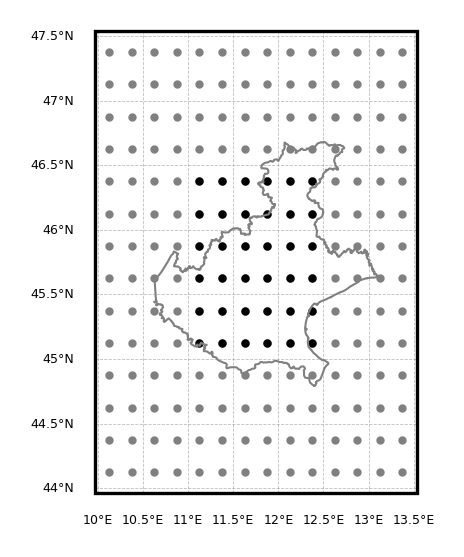

In [8]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')
ax1.scatter(lon2d, lat2d, s=1, c='grey')
ax1.scatter(lon2d_ref, lat2d_ref, s=1, c='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

In [9]:
def beta_3h_1dy(DATA_in, time_reso, lat_c, lon_c, PARAM):
    BOX = ART_pre.create_box_v2(DATA_in, lat_c, lon_c, PARAM['npix'])
    tscales = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]) 

    print(f"Neighborhood area: {BOX.sizes['lat']}x{BOX.sizes['lon']}")

    BOX = BOX.transpose("lon", "lat", "time")
    BOX = BOX['PRE']

    smax = BOX.shape[0]
    tscales = tscales[tscales < param['tmax'] + 0.001]
    xscales = np.arange(1, smax+1)
    xscales_km = xscales*param['L1']

    # ====================================================================================
    # Version 2
    WET_MATRIX = ART_pre.space_time_scales_agregations(
                                BOX, 
                                param['L1'], 
                                'FOCUS', 
                                tscales, 
                                xscales, 
                                2*param['npix']+1, 
                                param['thresh'])
    # ====================================================================================

    nxscales = np.size(xscales)

    tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), param['ninterp'])
    WET_MATRIX_INTER = np.zeros((param['ninterp'], nxscales))

    for col in range(nxscales):
        WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

    WET_MATRIX_EXTRA, new_spatial_scale = ART_pre.wet_matrix_extrapolation(
                                WET_MATRIX_INTER, 
                                xscales_km, 
                                tscales_INTER, 
                                param['L1'], 
                                param['npix'])

    origin_ref = [param['origin_x'], param['origin_t']]
    target_ref = [param['target_x'], param['target_t']]

    beta = ART_down.compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)

    return beta


In [10]:
def compute_for_point(lat_idx, lon_idx):
    return beta_3h_1dy(PRE_data, time_reso, lats[lat_idx], lons[lon_idx], param)

Resource = []

start_time = time.time()

results = Parallel(n_jobs=param['BETA_cores'])(
    delayed(compute_for_point)(la, lo) for la in ndices_lat for lo in ndices_lon
    )

end_time = time.time()

elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60
memory_consumed = psutil.virtual_memory().used / 1024 ** 3

print(f"Elapsed time: {elapsed_minutes:.2f} minutes")
print(f"Memory consumed: {memory_consumed:.3f} GB")

Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3Neighborhood area: 3x3

Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Elapsed time: 1.83 minutes
Memory consumed: 10.905 GB


In [11]:
BETA_VENETO = np.array(results).reshape(len(ndices_lat), len(ndices_lon))

In [12]:
from scipy.stats import pearsonr, spearmanr

In [13]:
def gamma_3h_1dy(DATA_in, time_reso, lat_c, lon_c, PARAM):
    if time_reso == '3h':
        PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)
        BOX = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, PARAM['npix'])
    elif time_reso == '1dy':
        BOX = ART_pre.create_box_v2(DATA_in, lat_c, lon_c, PARAM['npix'])
        PRE_daily = DATA_in
    else:
        print(f'Erorr: {time_reso} not valid')
        return None

    print(f"Neighborhood area: {BOX.sizes['lat']}x{BOX.sizes['lon']}")
    
    i_ = np.where(lats==lat_c)[0][0]
    j_ = np.where(lons==lon_c)[0][0]

    IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data
    IMERG_pixel_1dy_xr = xr.DataArray(
                IMERG_pixel_1dy, 
                coords={'time':PRE_daily['time'].values}, 
                dims=('time'))

    IMERG_WEIBULL_YEAR = ART_down.fit_yearly_weibull_update(
                    IMERG_pixel_1dy_xr, 
                    thresh=PARAM['thresh'], 
                    maxmiss=PARAM['maxmiss'])

#   ====================================================================================
    # vdist, vcorr = ART_pre.autocorrelation_neighborhood_v2(
    #                 BOX, 
    #                 time_reso, 
    #                 param['target_t'], 
    #                 param['thresh'])

    # mask = ~np.isnan(vdist) & ~np.isnan(vcorr)
    # vdist, vcorr = np.array(vdist)[mask], np.array(vcorr)[mask]

    # vdist_sorted = np.sort(vdist) # order distance
    # vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
    # toll_cluster = 0.5

    # cluster = np.zeros(len(vdist_sorted))
    # count = 0
    # for i in range(1, len(vdist_sorted)):
    #     if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
    #         cluster[i] = count
    #     else:
    #         count = count + 1
    #         cluster[i] = count

    # clust = set(cluster) # Extract only the uniques values
    # nclust = len(clust) # Numero de grupos

    # vdist_ave = np.zeros(nclust)
    # vcorr_ave = np.zeros(nclust)
    # for ei, elem in enumerate(clust):
    #     di = vdist_sorted[cluster==elem] # Distance
    #     ci = vcorr_sorted[cluster==elem] # Correlation
    #     vdist_ave[ei] = np.mean(di) # Mean Distance
    #     vcorr_ave[ei] = np.mean(ci) # Mean Correlation

#   ====================================================================================
    res = DOWN_raw.grid_corr(BOX['PRE'],plot=False,thresh=param['thresh'])
    vdist = res['vdist']
    vcorr = res['vcorr']
    
    res = DOWN_raw.bin_ave_corr(vdist, vcorr, toll=0.3, plot=False)
    vdist_ave = res['vdist_ave']
    vcorr_ave = res['vcorr_ave']

    # ==============================================================================
    # # Original: the best results
    bounds = [(0, 200),(0, 1)]
    tol = 0.005
    atol = 0.005
    # ==============================================================================

    def myfun(pardown):
        return ART_down.myfun_sse(vdist_ave, vcorr_ave, pardown, PARAM['L1'], acf=PARAM['acf'])

    resmin = differential_evolution(
                myfun,
                bounds,
                disp=True,
                tol=tol,
                atol=atol,
                workers=1,
                updating='deferred'
            )

    param1 = resmin.x[0]
    param2 = resmin.x[1]

    gamma = ART_down.gamma_manual(IMERG_WEIBULL_YEAR[:,0], 
                        IMERG_WEIBULL_YEAR[:,1], 
                        IMERG_WEIBULL_YEAR[:,2], 
                        PARAM['L1'], 
                        PARAM['L0'], 
                        (param1, param2), 
                        acf=PARAM['acf'])

    return gamma

In [14]:
def compute_for_point(lat_idx, lon_idx):
    return gamma_3h_1dy(PRE_data, time_reso, lats[lat_idx], lons[lon_idx], param)

Resource = []

start_time = time.time()

results = Parallel(n_jobs=param['GAMMA_cores'])(
    delayed(compute_for_point)(la, lo) for la in ndices_lat for lo in ndices_lon
    )

end_time = time.time()

elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60
# memory_consumed = psutil.virtual_memory().used / 1024 ** 3

print(f"Elapsed time: {elapsed_minutes:.2f} minutes")

Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Not enough data
Not enough data
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
Neighborhood area: 3x3
differential_evolution step 1: f(x)= 0.005844835317172008
differential_evolution step 1: f(x)= 0.004806379297210484
differential_evolution step 1: f(x)= 0.0007338713066640962
differential_evolution step 1: f(x)= 0.0007385110216811769
differential_evolution step 1: f(x)= 0.002503403026295548
differential_evolution step 1: f(x)= 0.0042278864114182

In [15]:
GAMMA_VENETO = np.array(results).reshape(len(ndices_lat), len(ndices_lon))

In [16]:
# PRE_daily = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

# num_processes = max(1, os.cpu_count() - 2)

# def process_point(args):
#     i, j, PRE_daily, lats, lons = args
#     TMP = ART_down.weibull_year_parameters(PRE_daily, lats[i], lons[j], 1, 40)
#     return i, j, TMP

# # Crear lista de argumentos
# args = [(i, j, PRE_daily, lats, lons) for i in range(len(ndices_lat)) for j in range(len(ndices_lon))]

# # Paralelizar cálculos
# with Pool(processes=num_processes) as pool:
#     results = pool.map(process_point, args)

# # Recolectar resultados
# N = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])
# C = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])
# W = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])

# for i, j, TMP in results:
#     N[:, i, j] = TMP[:, 0]
#     C[:, i, j] = TMP[:, 1]
#     W[:, i, j] = TMP[:, 2]

In [17]:
# NYs = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])
# CYs = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])
# WYs = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])

# for la in range(len(lat_ref)):
#     for lo in range(len(lon_ref)):
#         xdaily0 = PRE_1dy['PRE'][:,la,lo]
#         xdaily = xdaily0.dropna(dim='time', how='any')
#         NCWy, _ = DOWN_raw.fit_yearly_weibull(xdaily,1,40)
#         NYs[:,la,lo] = NCWy[:,0]
#         CYs[:,la,lo] = NCWy[:,1]
#         WYs[:,la,lo] = NCWy[:,2]

In [18]:
NYs = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])
CYs = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])
WYs = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])

for nla, la in enumerate(lat_ref):
    for nlo, lo in enumerate(lon_ref):
        tsc = PRE_1dy.loc[dict(lat = la, lon = lo)]
        NCWy, _ = DOWN_raw.fit_yearly_weibull(tsc['PRE'],1,40)
        NYs[:,nla,nlo] = NCWy[:,0]
        CYs[:,nla,nlo] = NCWy[:,1]
        WYs[:,nla,nlo] = NCWy[:,2]

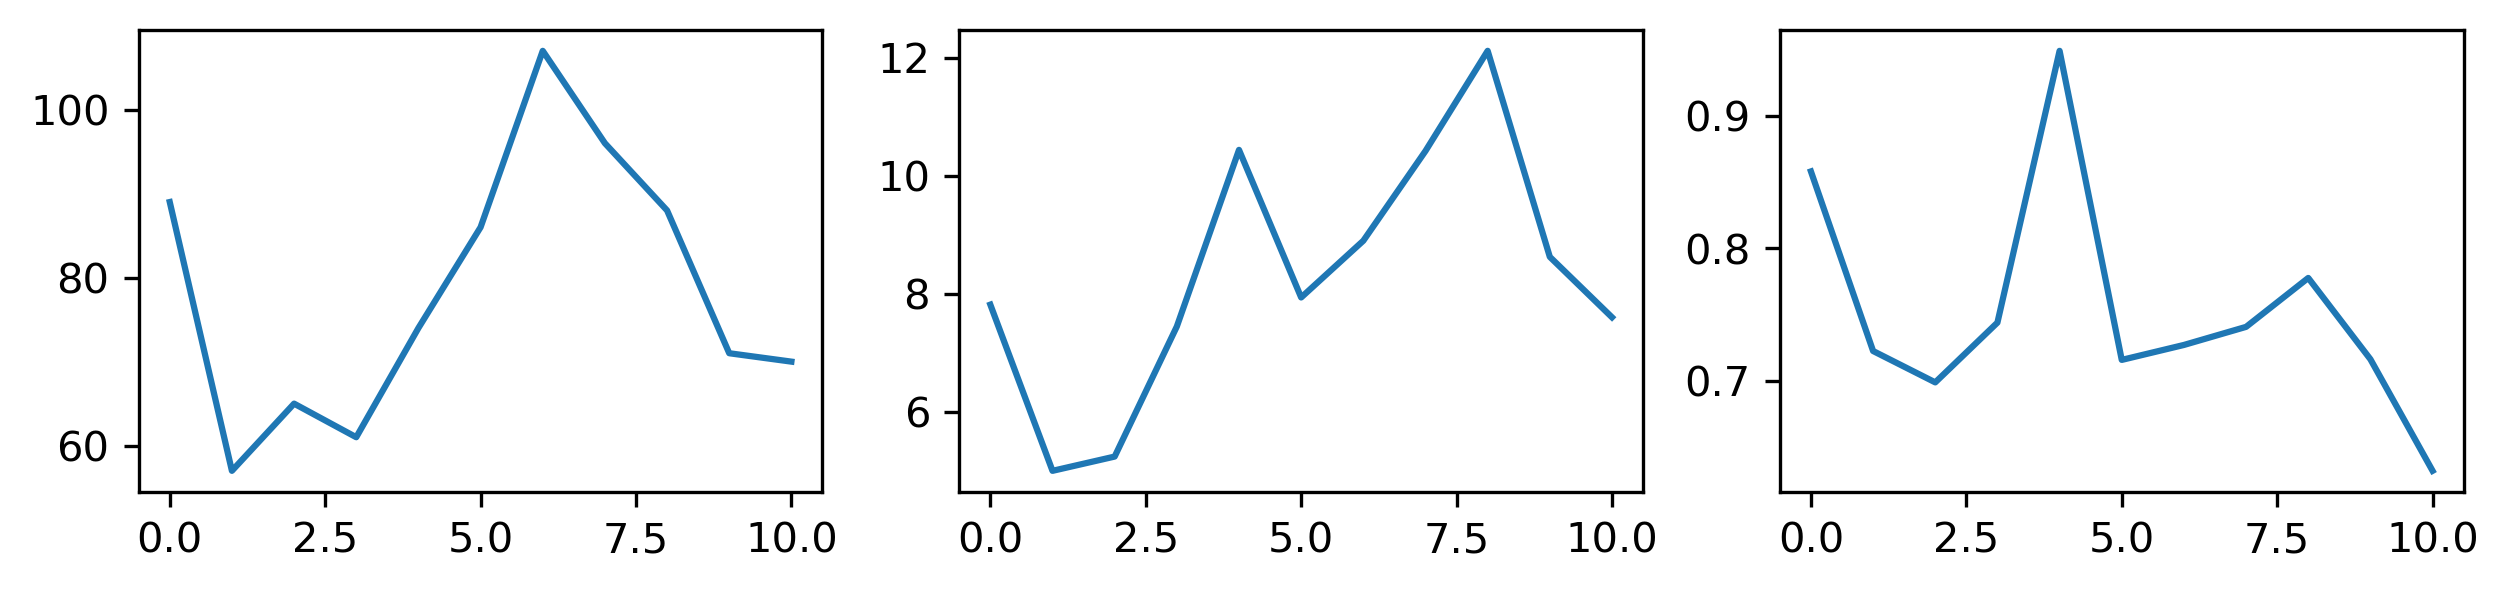

In [19]:
fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(NYs[:,2,2], label='ZOR')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(CYs[:,2,2], label='ZOR')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.plot(WYs[:,2,2], label='ZOR')

In [20]:
NYd, CYd, WYd = ART_down.down_year_parameters(NYs, CYs, WYs, BETA_VENETO, GAMMA_VENETO)

In [21]:
Nmin = np.min([np.min(NYs),np.min(NYd)])
Nmax = np.max([np.max(NYs),np.max(NYd)])
Nx = np.arange(Nmin,Nmax,1)

Cmin = np.min([np.min(CYs),np.min(CYd)])
Cmax = np.max([np.max(CYs),np.max(CYd)])
Cx = np.arange(Cmin,Cmax,0.1)

Wmin = np.min([np.min(WYs),np.min(WYd)])
Wmax = np.max([np.max(WYs),np.max(WYd)])
Wx = np.arange(Wmin,Wmax,0.1)

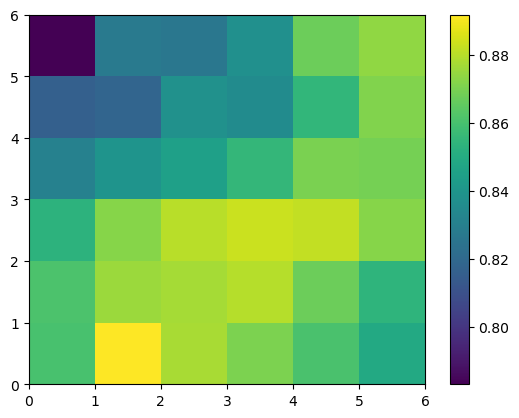

In [22]:
plt.pcolormesh((GAMMA_VENETO))
plt.colorbar()

In [23]:
np.where(WYd==np.max(WYd))

(array([2]), array([3]), array([1]))

Text(0.0, 1.0, '(c) Scatter plot of Shape')

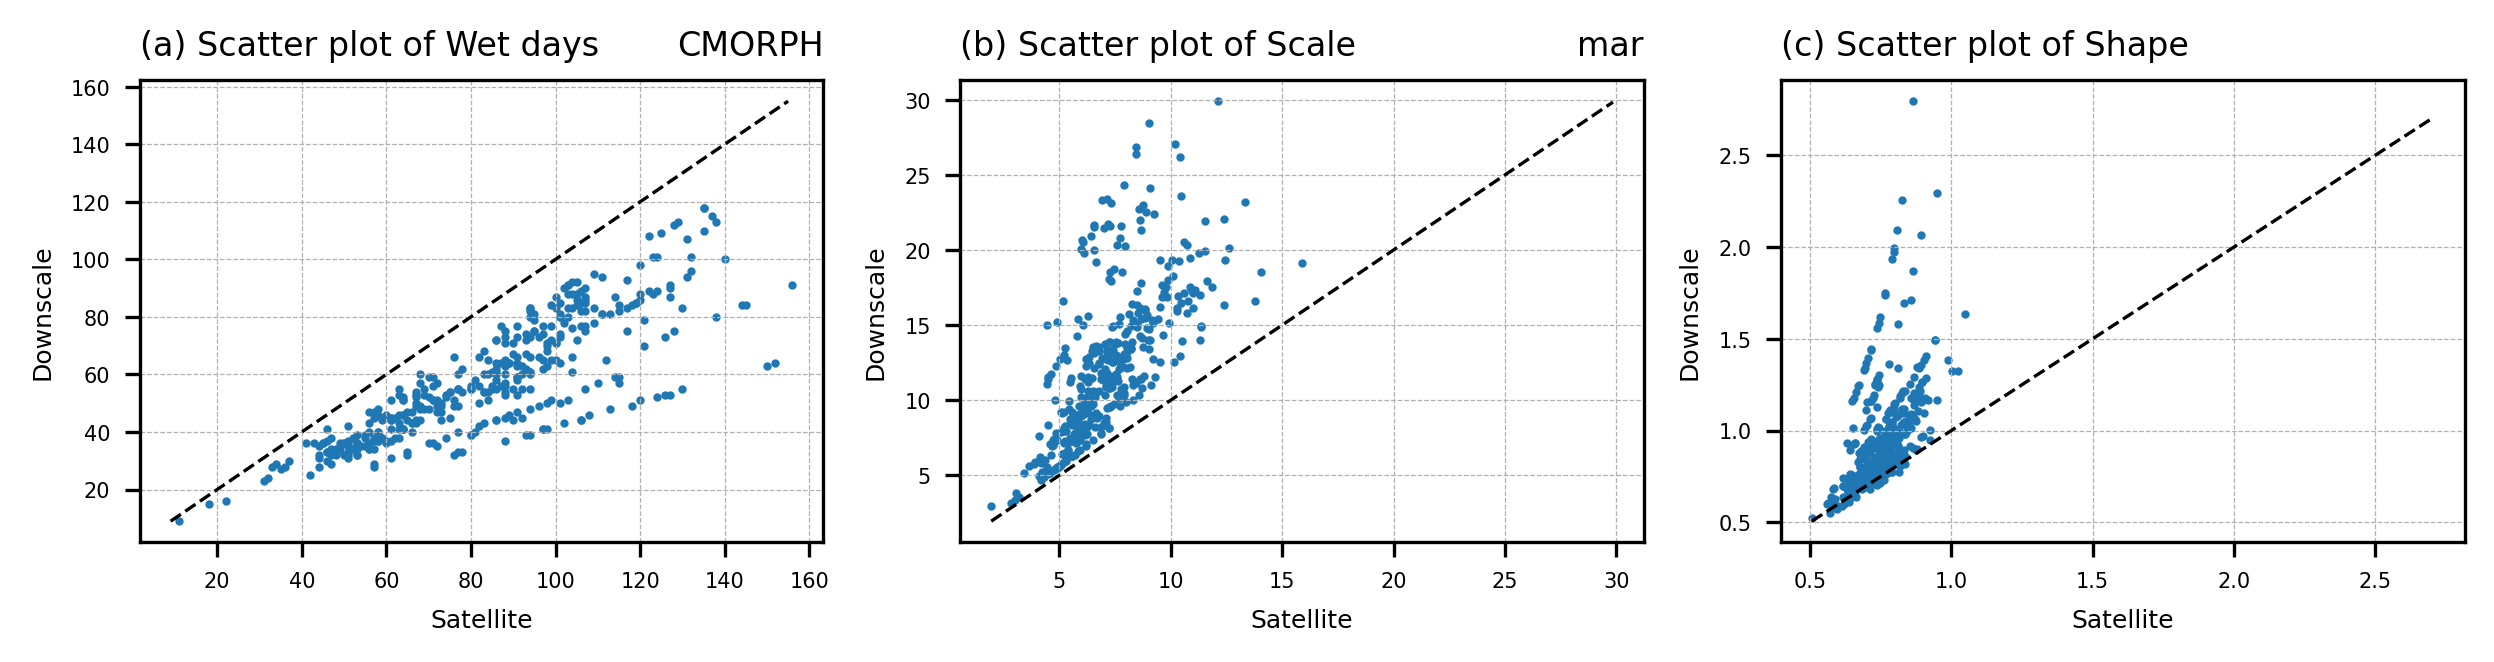

In [24]:
fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(NYs,NYd,s=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.plot(Nx,Nx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
ax1.set_xlabel('Satellite', fontsize=6)
ax1.set_ylabel('Downscale', fontsize=6)
ax1.set_title('(a) Scatter plot of Wet days', loc='left', fontsize=8)
ax1.set_title(product, loc='right', fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(CYs,CYd,s=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.plot(Cx,Cx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
ax1.set_xlabel('Satellite', fontsize=6)
ax1.set_ylabel('Downscale', fontsize=6)
ax1.set_title('(b) Scatter plot of Scale', loc='left', fontsize=8)
ax1.set_title(param['acf'], loc='right', fontsize=8)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(WYs,WYd,s=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.plot(Wx,Wx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
ax1.set_xlabel('Satellite', fontsize=6)
ax1.set_ylabel('Downscale', fontsize=6)
ax1.set_title('(c) Scatter plot of Shape', loc='left', fontsize=8)


In [25]:
Tr = [5, 10, 20, 50, 100, 200]
Q = ART_down.pre_quantiles_array(NYs, CYs, WYs, Tr, lat_ref, lon_ref, 1)
QD = ART_down.pre_quantiles_array(NYd, CYd, WYd, Tr, lat_ref, lon_ref, 1)

In [26]:
DOWN_xr = xr.Dataset(data_vars={
                    "NYs": (("year","lat","lon"), NYs),
                    "CYs": (("year","lat","lon"), CYs),
                    "WYs": (("year","lat","lon"), WYs),
                    "Mev_s": (("Tr","lat","lon"), Q),
                    "NYd": (("year","lat","lon"), NYd),
                    "CYd": (("year","lat","lon"), CYd),
                    "WYd": (("year","lat","lon"), WYd),
                    "Mev_d": (("Tr","lat","lon"), QD),
                    },
                    coords={'year':year_vector,'Tr':Tr,'lat': lat_ref, 'lon': lon_ref},
                    attrs=dict(description=f"Yearly Weibull Paramaters Downscale using {product} for Veneto region limited as 10.5E to 13.5E and 44.5N to 47N"))

DOWN_xr.NYs.attrs["units"] = "day"
DOWN_xr.NYs.attrs["long_name"] = "Number of wet days"
DOWN_xr.NYs.attrs["origname"] = "wet days"

DOWN_xr.CYs.attrs["units"] = "dimensionless"
DOWN_xr.CYs.attrs["long_name"] = "Weibull scale parameter"
DOWN_xr.CYs.attrs["origname"] = "scale"

DOWN_xr.WYs.attrs["units"] = "dimensionless"
DOWN_xr.WYs.attrs["long_name"] = "Weibull shape parameter"
DOWN_xr.WYs.attrs["origname"] = "shape"

DOWN_xr.Mev_s.attrs["units"] = "mm/day"
DOWN_xr.Mev_s.attrs["long_name"] = "Satellite Maximum Quantiles"
DOWN_xr.Mev_s.attrs["origname"] = "Satellite quantiles"

DOWN_xr.NYd.attrs["units"] = "day"
DOWN_xr.NYd.attrs["long_name"] = "Downscale Number of wet days"
DOWN_xr.NYd.attrs["origname"] = "down wet days"

DOWN_xr.CYd.attrs["units"] = "dimensionless"
DOWN_xr.CYd.attrs["long_name"] = "Downscale Weibull scale parameter"
DOWN_xr.CYd.attrs["origname"] = "down scale"

DOWN_xr.WYd.attrs["units"] = "dimensionless"
DOWN_xr.WYd.attrs["long_name"] = "Downscale Weibull shape parameter"
DOWN_xr.WYd.attrs["origname"] = "down shape"

DOWN_xr.Mev_d.attrs["units"] = "mm/day"
DOWN_xr.Mev_d.attrs["long_name"] = "Downscaling Maximum Quantiles"
DOWN_xr.Mev_d.attrs["origname"] = "Downscaling quantiles"

DOWN_xr.lat.attrs["units"] = "degrees_north"
DOWN_xr.lat.attrs["long_name"] = "Latitude"

DOWN_xr.lon.attrs["units"] = "degrees_east"
DOWN_xr.lon.attrs["long_name"] = "Longitude"

In [27]:
DOWN_out = os.path.join(dir_base,'Satellite','4_TEST',f'VENETO_DOWN_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{param['npix']}_thr_{param['thresh']}_acf_{param['acf']}_ART.nc')
print(f'Export PRE data to {DOWN_out}')
DOWN_xr.to_netcdf(DOWN_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Satellite/4_TEST/VENETO_DOWN_CMORPH_3h_2002_2012_npix_1_thr_1_acf_mar_ART.nc


In [28]:
playsound("../sound/HOMER_DOH.mp3")